<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/6_LSTM_prediction_BTC_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
# from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction/btc_only_specific_time.csv', parse_dates=True, index_col="time")
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
# Data normalization. This is one of the first steps to normalize the values. 
# The goal is to change the values of numeric columns in the data set to a common scale, wihtout distorting differeces in the randes of values. 
df_values = df.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

print(len(data_scaled))

182


In [12]:
# Splitting data into training and testing data 

train_index = int(0.7 * len(data_scaled))
val_index = train_index + int(0.05 * len(data_scaled))

train = data_scaled[:train_index]
val = data_scaled[train_index:val_index]
test = data_scaled[val_index:]

In [13]:
print("train,test,val",train.shape, test.shape, val.shape)

train,test,val (127, 1) (46, 1) (9, 1)


In [14]:
xtrain , ytrain, xtest, ytest = train[:-1], train[1:], test[:-1], test[1:]

In [15]:
xval , yval = val[:-1], val[1:]

In [16]:
print(xtrain.shape)
print(ytrain.shape)
print(len(xtrain))

(126, 1)
(126, 1)
126


In [21]:
# Samples -> these are the rows in the data.

timesteps = 1 # Timesteps -> these are the past observations for a feature (such as lag variable).
n_features = 1 # Columns in the data. Should be set to 1 since we only have 'close' column. 

train_len = len(xtrain) - timesteps
test_len = len(xtest) - timesteps
val_len = len(xval) - timesteps

x_train = np.zeros((train_len, timesteps, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+timesteps
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, timesteps, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+timesteps
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, timesteps, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+timesteps
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

# 2 hidden layers with 50 neurons each and a dropout between every one of them. 
# Start with Sequencial class. 
model = Sequential() 

# return_sequence will return a sequence rather than a single value for each input.
# Sequential model -> as apipeline with raw data fed in
model.add(LSTM(50, input_shape = (timesteps, n_features), return_sequences=True, activation='relu'))
model.add(Dropout(0.15))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) # This layer is at the end of the architecture and it is used for outputting a prediction.
# model.add(Activation('linear'))
print(model.summary())

# mean-squared-error loss function and Adam optimiser. MSE is a standard loss function for a regression model.
# adam -> optimiser algorithm
model.compile(loss = 'mean_squared_error', optimizer = 'adam') #, metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train, y_train, epochs = 20, batch_size=2, 
          validation_data=(x_val, y_val), verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

x_train (125, 1, 1)
y_train (125,)
x_test (44, 1, 1)
y_test (44,)
x_val (7, 1, 1)
y_val (7,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_______________________

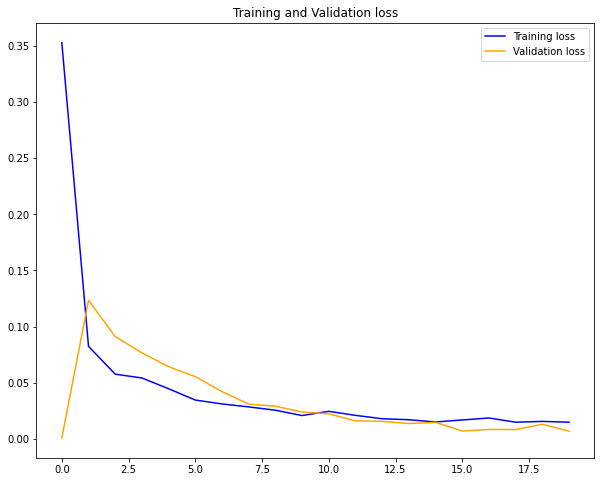

r2_score: -3.8785661831715617


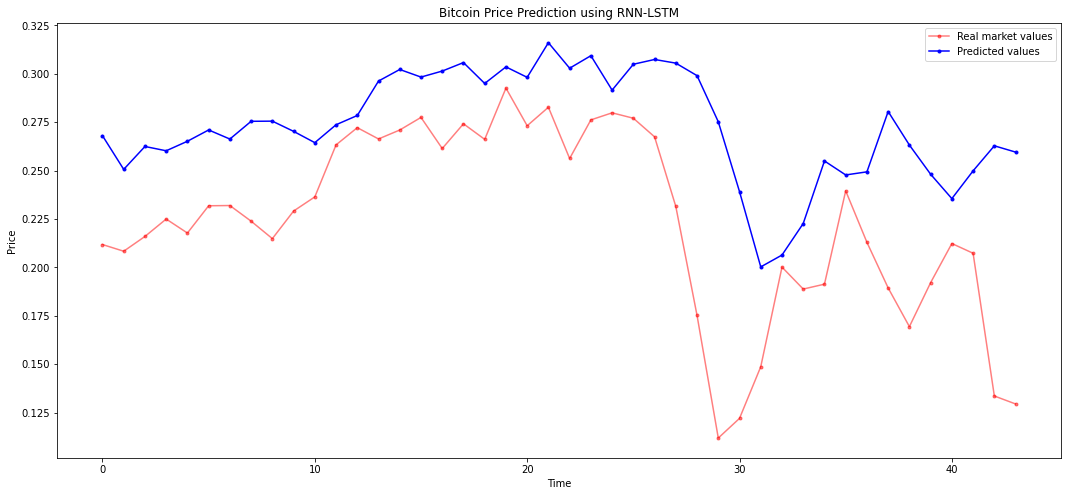

In [22]:
# Plotting data 

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()

# Predict the model
y_pred = model.predict(x_test)
print("r2_score:", r2_score(y_pred, y_test))

plt.figure(figsize=(18,8))
plt.plot(y_test, '.-', color='red', label='Real market values', alpha=0.5)
plt.plot(y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.title("Bitcoin Price Prediction using RNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()